# Imports

In [ ]:
from keras.utils.np_utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import glob
from skimage.morphology import medial_axis
from skimage import img_as_ubyte
from  scipy import ndimage
from keras.models import load_model
from skimage.morphology import medial_axis, label
import math
from skimage.measure import label, regionprops
import random

# Get images

## Get zip images (dropbox) 200

In [ ]:
!wget -O data.zip https://www.dropbox.com/s/n6odgiacnysw9qg/benchmarkdataset.zip?dl=0
!unzip /content/data.zip

--2022-06-02 17:49:40--  https://www.dropbox.com/s/n6odgiacnysw9qg/benchmarkdataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/n6odgiacnysw9qg/benchmarkdataset.zip [following]
--2022-06-02 17:49:40--  https://www.dropbox.com/s/raw/n6odgiacnysw9qg/benchmarkdataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc5dab6a1f4f4f14639f2a0acd4.dl.dropboxusercontent.com/cd/0/inline/BmcxA-Ngcfmn1HIuAIb0_mRT-2mVnNfRcQaBh39vl345ixwnbiGksWbINH4wXGHWK6GTAcDYho1BRrM_kDfauuxUOkvdU5w2Nx4wSyQkq7o4Whhr-3owDjq1_u8rl-UKlnMo_E_od2JrNk3JGrdU9COJ6UKQvp7sGaX9VB_LTirA_w/file# [following]
--2022-06-02 17:49:45--  https://ucc5dab6a1f4f4f14639f2a0acd4.dl.dropboxusercontent.com/cd/0/inline/BmcxA-Ngcfmn1HIuAIb0_mRT-2mVnNfRcQaBh3

## Process dataset

In [ ]:
image_directory = "/content/images"
mask_directory =  "/content/masks"

In [ ]:
image_names = glob.glob(f"{image_directory}/*.jpg")
image_names.sort()


image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  

for image_name in image_names:    #Remember enumerate method adds a counter and returns the enumerate object
      image = cv2.imread(image_name, 1)
      image = Image.fromarray(image)
      image_dataset.append(np.array(image))

In [ ]:
mask_names = glob.glob(f"{mask_directory}/*.png")
mask_names.sort()

mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

for image_name in mask_names:
        image = cv2.imread(image_name, 0)
        image = np.where(image>0, 255, image)
        image = Image.fromarray(image)
        mask_dataset.append(np.array(image))

In [ ]:
check_all_names = []
for i in range(len(os.listdir(mask_directory))):
  img_name = image_names[i].split("/")[-1]
  mask_name = mask_names[i].split("/")[-1]

  n1 = img_name.split(".")[0]
  n2 = mask_name.split(".")[0]
  check_all_names.append(n1==n2)

all(check_all_names)

True

In [ ]:
#Normalize images
image_dataset = np.array(image_dataset)/255.
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

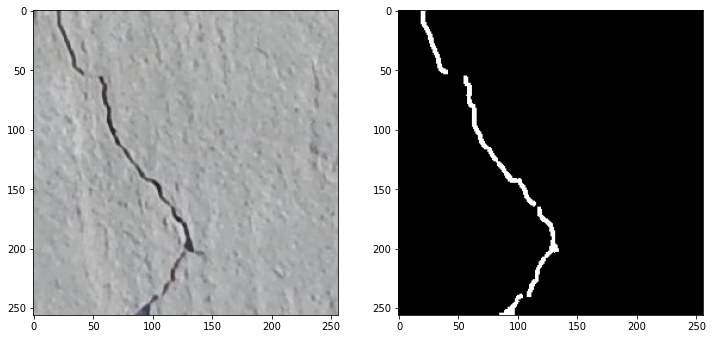

In [ ]:
#Sanity check, view few mages
image_number = random.randint(0, len(mask_dataset)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (256,256,3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (256,256)), cmap='gray')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.2, random_state = 9)

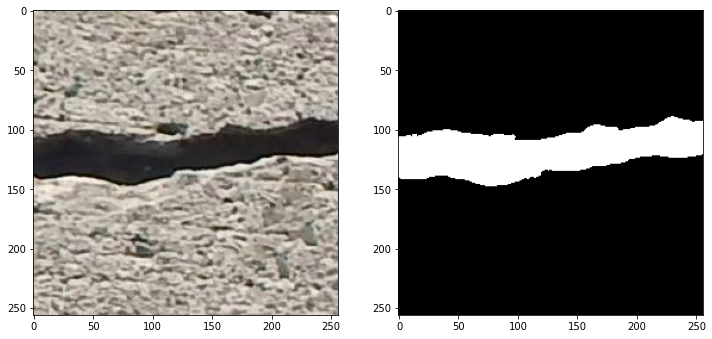

In [ ]:
#Sanity check, view few mages
image_number = random.randint(0, len(X_test)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_test[image_number], (256,256,3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_test[image_number], (256,256)), cmap='gray')

# Crack measurement function

In [ ]:
# crack instance segment

def instance_segment(np_image): 
  # get crack
  # im_original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  rgb_original = cv2.cvtColor(np_image, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose
  if len(np.unique(np_image)) == 1:
    # print("no crack")
    return np_image, 0

  labeled = label(np_image, background=0)
  pixel_values = np.unique(labeled)
  cracks = [np.where(labeled != label, 0, labeled) for label in pixel_values]
  del cracks[0]

  return cracks

In [ ]:
from skimage.morphology import skeletonize
def filter_crack_instances(cracks, np_image):

  instances = []
  for crack_instance in cracks:
      im = crack_instance.astype(np.uint8) * 255
      rgb = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose
      _, crack = cv2.threshold(im, 50, 255, cv2.THRESH_BINARY)
      
      # get medial axis
      med_plot = np.zeros((256,256), np.uint8)
      medial, distance = medial_axis(im, return_distance=True)
      med_img = img_as_ubyte(medial)
      med_contours, _ = cv2.findContours(med_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
      cv2.drawContours(med_plot, med_contours, -1, (255, 0, 0), 1)
      med_pts = [v[0] for v in med_contours[0]]

      # get point with maximal distance from medial axis
      max_idx = np.argmax(distance)
      max_pos = np.unravel_index(max_idx, distance.shape)
      max_dist = distance[max_pos]
      coords = np.array([max_pos[1], max_pos[0]])
      # print(f"max distance from medial axis to boundary = {max_dist} at x,y: {coords}")

      border_values = {0, 256}
      if coords[1] in border_values or coords[0] in border_values:
        continue

      # interpolate orthogonal of medial axis at coords
      delta = 3
      try:
          idx = next(i for i, v in enumerate(med_pts) if (v == coords).all())
      except StopIteration:
          continue

      px1, py1 = med_pts[(idx-delta) % len(med_pts)]
      px2, py2 = med_pts[(idx+delta) % len(med_pts)]
      orth = np.array([py1 - py2, px2 - px1]) * max(im.shape)
      # intersect orthogonal with crack and get contour
      orth_img = np.zeros(im.shape, dtype=np.uint8)
      A = tuple(coords + orth)
      B = tuple(coords - orth)
      cv2.line(orth_img, A, B, color=255, thickness=1)
      gap_img = cv2.bitwise_and(orth_img, crack)

      gap_contours, _ = cv2.findContours(gap_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      gap_pts = [v[0] for v in gap_contours[0]]

      if len(gap_pts) == 1:
        continue

      # determine the end points of the gap contour by negative dot product
      n = len(gap_pts)
      gap_ends = [
      p for i, p in enumerate(gap_pts)
      if np.dot(p - gap_pts[(i-1) % n], gap_pts[(i+1) % n] - p) < 0
      ]
      # print(f"Maximum gap found from {gap_ends[0]} to {gap_ends[1]}")

      C = tuple(gap_ends[0])
      D = tuple(gap_ends[1])
      distance = round(calculate_euclidean_distance(C,D),3)
      instances.append([[C,D], distance])
      
  return instances

In [ ]:
def calculate_euclidean_distance(p1,p2):
  s1 = (math.pow(p1[0] - p2[0],2))
  s2 = (math.pow(p1[1] - p2[1],2))
  euclidean_distance = math.sqrt(s1+s2)
  return euclidean_distance


def get_boundary(numpy_img, pixel_value):
  canny_Img = cv2.Canny(numpy_img,100,200)
  contours,_ = cv2.findContours(canny_Img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  canvas = np.zeros_like(numpy_img)
  boundary = cv2.drawContours(canvas , contours, -1, pixel_value, 1)
  return boundary


def crack_measurement(np_image): 
  # get crack
  # im_original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  rgb_original = cv2.cvtColor(np_image, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose
  if len(np.unique(np_image)) == 1:
    # print("no crack")
    return np_image, 0

  labeled = label(np_image, background=0)
  pixel_values = np.unique(labeled)
  cracks = [np.where(labeled != label, 0, labeled) for label in pixel_values]
  if len(cracks) > 1:
    del cracks[0]

  crack_list = filter_crack_instances(cracks, np_image)
  if crack_list == []:
    return np_image, 0

  crack_line_points = []
  d = 0
  for crack_prop in crack_list:
    if crack_prop[1] > d:
      d = crack_prop[1] 
      crack_line_points = crack_prop[0]

  rgb_original = cv2.line(rgb_original, crack_line_points[0], crack_line_points[1], color=(0, 0, 255), thickness=1)
  text = str(d) + "px"
  rgb_original = cv2.putText(rgb_original, text, (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)


  return rgb_original, d

# Load models 

In [ ]:
!pip install keras_unet_collection
from keras_unet_collection.transformer_layers import patch_extract, patch_embedding
from keras_unet_collection.activations import GELU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 3.9 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# BEST MODELS
from tensorflow.keras import backend as K
#U-Net
unet_path = "/content/gdrive/MyDrive/25may/unet.epoch23-dice_coef0.85.hdf5"
unet_model = load_model(unet_path, compile=False)

#Attention U-Net 
att_unet_path = "/content/gdrive/MyDrive/25may/att_unet.epoch33-dice_coef0.83.hdf5" 
att_unet_model = load_model(att_unet_path, compile=False)

#Trans U-Net 
transunet_path = "/content/gdrive/MyDrive/25may/trans_unet.epoch38-dice_coef0.85.hdf5"
transunet_model = load_model(transunet_path, compile=False, custom_objects={"patch_extract": patch_extract, "patch_embedding": patch_embedding, "GELU": GELU})

#Trans U-Net ResNet50V2
transunet_resnet_path = "/content/gdrive/MyDrive/keras_unet_collection/trans-unet-resnet/trans_unet_resnet.epoch26-dice_coef0.86.h5"
transunet_resnet_model = load_model(transunet_resnet_path, compile=False, custom_objects={"patch_extract": patch_extract, "patch_embedding": patch_embedding, "GELU": GELU})

In [ ]:
models = {"unet": unet_model, 
          "att_unet":att_unet_model, 
          "trans_unet":transunet_model,
          "trans_unet_resnet": transunet_resnet_model
          }

# STEP BY STEP

analyzing image number: 67


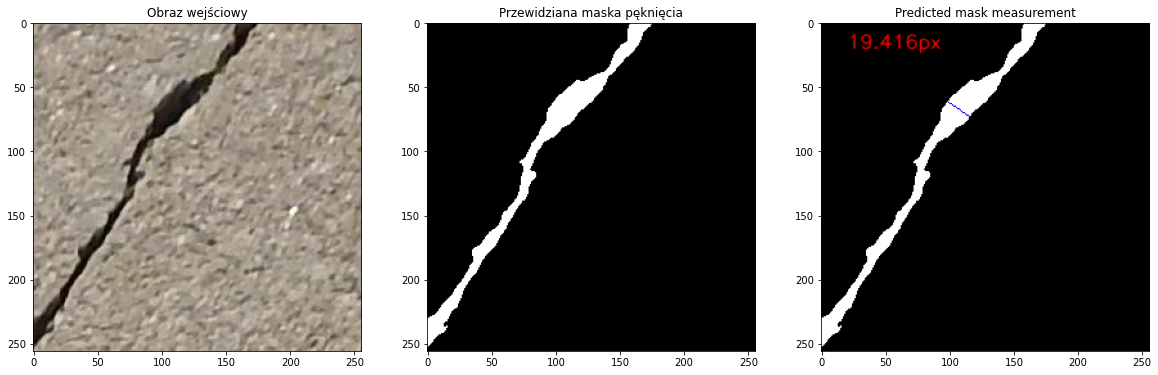

In [ ]:
#67, 61
image_number = random.randint(0, len(image_dataset))

image_number = 67
print(f"analyzing image number: {image_number}")
#original image

#load ground-truth image
image = np.reshape(image_dataset[image_number], (256,256,3))

#predict
model = models["unet"]
threshold = 0.5
prediction = (model.predict(np.expand_dims(image, 0))[0,:,:,0] > threshold).astype(np.uint8)
prediction_measurement, predicted_distance = crack_measurement(prediction.astype(np.uint8) * 255)


plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.title('Obraz wejściowy')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Przewidziana maska pęknięcia')
plt.imshow(prediction, cmap='gray')
plt.subplot(133)
plt.title('Predicted mask measurement')
plt.imshow(prediction_measurement, cmap='gray')

## visualize img

analyzing image number: 67


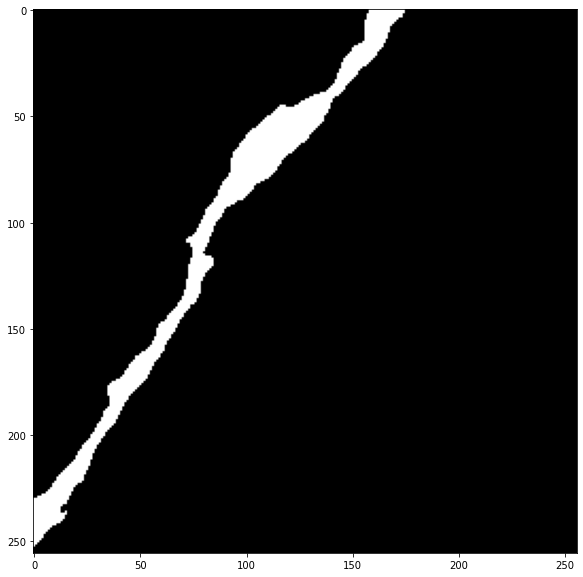

In [ ]:

print(f"analyzing image number: {image_number}")
image = np.reshape(image_dataset[image_number], (256,256,3))

model = models["unet"]

threshold = 0.5
prediction = (model.predict(np.expand_dims(image, 0))[0,:,:,0] > threshold).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.imshow(prediction, cmap="gray")

In [ ]:
np_image = prediction.astype(np.uint8) * 255

rgb_original = cv2.cvtColor(np_image, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose

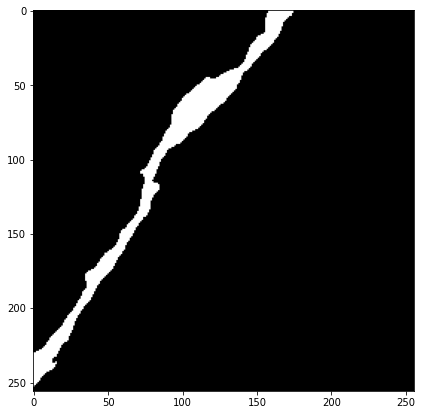

In [ ]:
im = np_image

plt.figure(figsize=(7, 7))
plt.imshow(im, cmap="gray")

rgb = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose
_, crack = cv2.threshold(im, 50, 255, cv2.THRESH_BINARY)

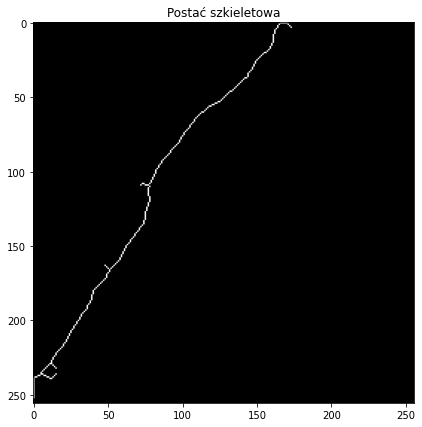

In [ ]:
# get medial axis
med_plot = np.zeros((256,256), np.uint8)
medial, distance = medial_axis(im, return_distance=True)
med_img = img_as_ubyte(medial)

plt.figure(figsize=(7, 7))
plt.title("Postać szkieletowa")
plt.imshow(med_img, cmap="gray")

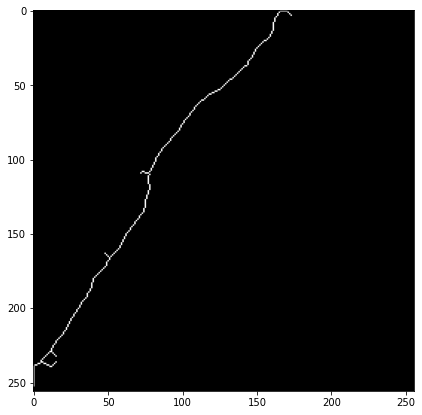

In [ ]:
med_contours, _ = cv2.findContours(med_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(med_plot, med_contours, -1, (255, 0, 0), 1)

plt.figure(figsize=(7, 7))
plt.imshow(med_plot, cmap="gray")

med_pts = [v[0] for v in med_contours[0]]

In [ ]:
# get point with maximal distance from medial axis
max_idx = np.argmax(distance)
max_pos = np.unravel_index(max_idx, distance.shape)
max_dist = distance[max_pos]
coords = np.array([max_pos[1], max_pos[0]])
print(f"max distance from medial axis to boundary = {max_dist} at x,y: {coords}")

max distance from medial axis to boundary = 10.63014581273465 at x,y: [107  67]


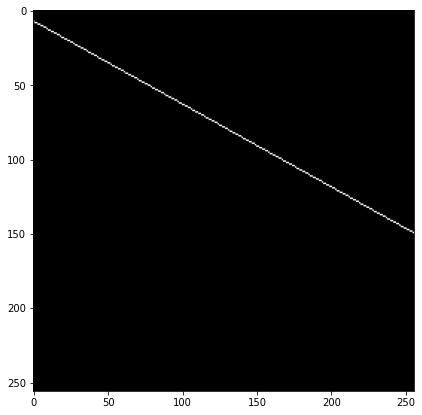

In [ ]:
# interpolate orthogonal of medial axis at coords
delta = 200
try:
    idx = next(i for i, v in enumerate(med_pts) if (v == coords).all())
except StopIteration:
    print("here2")
    

px1, py1 = med_pts[(idx-delta) % len(med_pts)]
px2, py2 = med_pts[(idx+delta) % len(med_pts)]
orth = np.array([py1 - py2, px2 - px1]) * max(im.shape)
# intersect orthogonal with crack and get contour

orth_img = np.zeros(im.shape, dtype=np.uint8)
A = tuple(coords + orth)
B = tuple(coords - orth)
cv2.line(orth_img, A, B, color=255, thickness=1)


plt.figure(figsize=(7, 7))
plt.imshow(orth_img, cmap="gray")

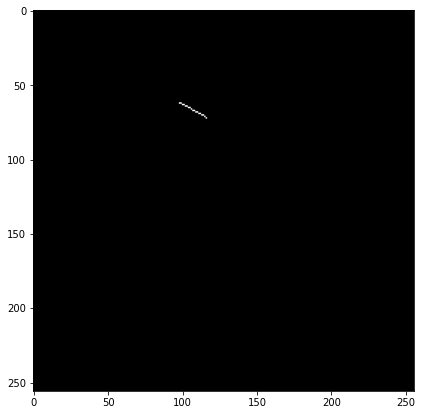

In [ ]:
gap_img = cv2.bitwise_and(orth_img, crack)

plt.figure(figsize=(7, 7))
plt.imshow(gap_img, cmap="gray")

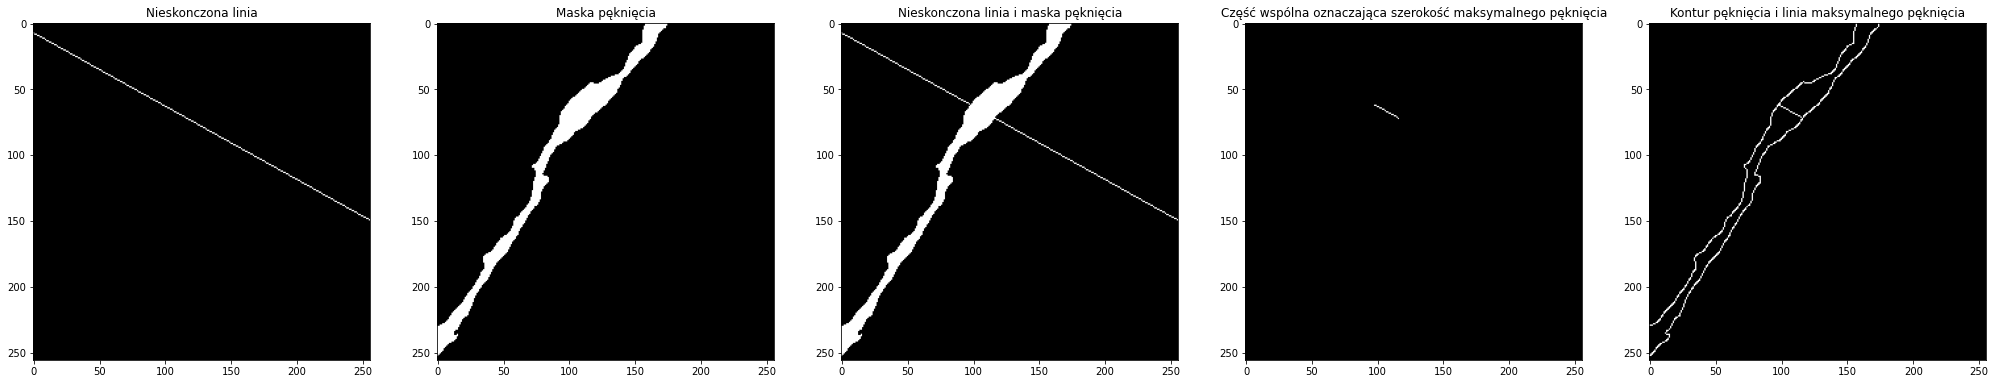

In [ ]:
crack_and_orth = orth_img + crack

boundary = get_boundary(im,255) 
boundary_and_gap = boundary + gap_img



plt.figure(figsize=(35, 35))
plt.subplot(151)
plt.title('Nieskonczona linia')
plt.imshow(orth_img, cmap='gray')
plt.subplot(152)
plt.title('Maska pęknięcia')
plt.imshow(crack, cmap='gray')
plt.subplot(153)
plt.title('Nieskonczona linia i maska pęknięcia')
plt.imshow(crack_and_orth, cmap='gray')
plt.subplot(154)
plt.title('Część wspólna oznaczająca szerokość maksymalnego pęknięcia')
plt.imshow(gap_img, cmap='gray')
plt.subplot(155)
plt.title('Kontur pęknięcia i linia maksymalnego pęknięcia')
plt.imshow(boundary_and_gap, cmap='gray')


In [ ]:
gap_contours, _ = cv2.findContours(gap_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
gap_pts = [v[0] for v in gap_contours[0]]

# determine the end points of the gap contour by negative dot product
n = len(gap_pts)
gap_ends = [
p for i, p in enumerate(gap_pts)
if np.dot(p - gap_pts[(i-1) % n], gap_pts[(i+1) % n] - p) < 0
]

print(f"Maximum gap found from {gap_ends[0]} to {gap_ends[1]}")

Maximum gap found from [98 62] to [116  72]


In [ ]:
C = tuple(gap_ends[0])
D = tuple(gap_ends[1])
distance = round(calculate_euclidean_distance(C,D),3)
print(f"crack width = {distance}")

crack width = 20.591


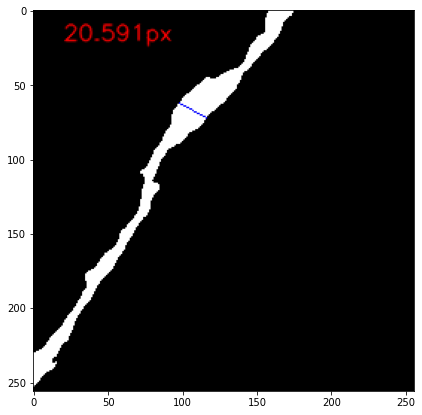

In [ ]:
rgb_original = cv2.line(rgb_original, C, D, color=(0, 0, 255), thickness=1)
text = str(distance) + "px"
rgb_original = cv2.putText(rgb_original, text, (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

plt.figure(figsize=(7, 7))
plt.imshow(rgb_original)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


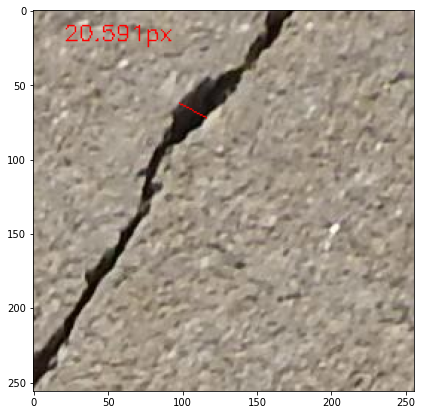

In [ ]:
rgb_original = cv2.line(image, C, D, color=(255, 0, 0), thickness=1)
text = str(distance) + "px"
rgb_original = cv2.putText(image, text, (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

plt.figure(figsize=(7, 7))
plt.imshow(image)